# Supplement B
# Drop Size Distribution retrieval


In the following, we introduce the use of the pyOptimalEstimation Python library using a radar-based drop-size distribution (DSD) retrieval as an example. 
Williams et al. (2014) suggested to parameterize a DSD using a scaling parameter $N_w$ as well as the raindrop mass spectrum mean diameter $D_m$ and its standard deviation $\sigma_m$.
Assuming that the DSD follows a gamma distribution, $\sigma_m$ is related to the shape parameter $\mu$ with 
\begin{equation} 
    \mu = (D_m/\sigma)^2 -4
\end{equation}
and we reconstruct the original DSD $N(D)$ as a function of maximum dimension $D$ with
\begin{equation}
    N(D) = N_w \frac{6}{256} \frac{(4+\mu)^{\mu+4}}{\Gamma(\mu+4)} \Big(\frac{D}{D_m}\Big)^{\mu} \exp \Big[ -(4+\mu) \frac{D}{D_m}\Big]
\end{equation}
using the normalization approach by \citet{testud_concept_2001}.

Williams et al. (2014) analyzed the correlations between $D_m$ and $\sigma_m$ in  detail and proposed to use a modified quantity $\sigma_m\!'$ defined with 
\begin{equation}
    \sigma_m\!' = \sigma_m D_m^{-1.36}
\end{equation}
in order to minimize the correlation to $D_m$. The three parameters required to estimate the DSD ($N_w$, $D_m$, and $\sigma_m$ or $\sigma_m\!'$) will form our state vector $\mathbf{x}$. 


A radar simulator will use $\mathbf{x}$ to estimate the measurement vector $\mathbf{y}$ consisting of the radar reflectivity factor ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$) with 
    \begin{equation}
    Z_e = 10 \times \log_{10} (10^{18} \times \sum_i N(D_i) \times \frac{\lambda^4}{|K_w|^2 \pi^5} \times \sigma(D_i) \times \Delta D ) 
    \end{equation}  
and
        \begin{equation}
V_d = \frac{\sum_i v(D_i) \times N(D_i) \times  \sigma(D_i) \times \Delta D}{\sum_i N(D_i) \times  \sigma(D_i) \times \Delta D}
    \end{equation}
where $i$ the index of the discrete DSD and $\sigma$ and $v$ are the functions to describe backscattering cross section and fall velocity, respectively. This means we have two measurements to derive three quantities of the state space, i.e. the problem is not unambiguous. 
In order to obtain the required prior data set, we use the Huntsville data set introduced in Williams et al. (2014) which consists of 18969 individual DSD distributions obtained at Huntsville, AL from December 2009 to October 2011. For every DSD, Williams et al. (2014) determined $N_w$, $D_m$, and $\sigma_m$ and we determine the a-priori assumption $\mathbf{x}_a$ and uncertainty ($\mathbb{S}_a$) form the mean and the covariance of the data set, respectively. 

# Installation 
In order to design a retrieval with pyOptimalEstimation, we need to install the library first with 
~~~~  
pip install pyOptimalEstimation
~~~~ 
for Python 2.7 or Python 3. This example uses Python 3.6. It requires the numpy, scipy, pandas and matplotlib libraries to be installed, this example makes use also of the xarray, seaborn, uncertainties, and xarray libraries. For development, we used Numpy 1.16.2, Matpolotlib 3.0.3, Scipy 1.2.1, Xarray 0.11.3, Pandas 0.24.1, Seaborn 0.9.0 and Uncertainties 3.0.3. 

The radar simulations are done with the Passive and Active Microwave radiative TRAnsfer model (PAMTRA, Mech et al. 2020). Here, we use version 2 that is in active development, so we install a specific version with:
~~~~ 
pip install git+git://github.com/maahn/pamtra2.git@461b711ae366b791665687de5dec37abd7ab78f5
~~~~ 

# Preparation

We start with loading the required libraries

In [262]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pn
import xarray as xr
import uncertainties.unumpy as unp
import seaborn as sns

import pamtra2

import pyOptimalEstimation as pyOE

%matplotlib inline
sns.set(style='ticks', palette='deep')
abc = 'abcdefghijklmopqrstuvwxyz'

We put some helper routines in a separate file which we load with 

In [2]:
import sys
sys.path.append('lib')
import supporting_routines

In [3]:
from importlib import reload
reload(supporting_routines)

<module 'supporting_routines' from 'lib/supporting_routines.py'>

## State vector

In order to load the required prior data set, we load the Huntsville data set of Williams et al. (2014) from a netCDF file using xarray:

In [4]:
rainDat = xr.open_dataset('data/huntsville_parameters.nc')[['Dm','Nw','Smprime']]

and add logarithmic variables with

In [5]:
rainDat['Nw_log10'] = np.log10(rainDat['Nw'])
rainDat['Dm_log10'] = np.log10(rainDat['Dm'])
rainDat['Smprime_log10'] = np.log10(rainDat['Smprime'])

rainDat

<xarray.Dataset>
Dimensions:        (time: 18969)
Coordinates:
  * time           (time) datetime64[ns] 2009-12-13T04:24:00 ... 2011-04-04T21:51:00
Data variables:
    Dm             (time) float64 1.117 1.003 1.014 1.112 ... 1.377 1.475 1.476
    Nw             (time) float64 2.328e+03 4.55e+03 ... 3.125e+03 1.156e+03
    Smprime        (time) float64 0.3058 0.2524 0.2513 ... 0.3837 0.3386 0.3318
    Nw_log10       (time) float64 3.367 3.658 4.037 3.925 ... 3.581 3.495 3.063
    Dm_log10       (time) float64 0.04817 0.001143 0.00605 ... 0.1689 0.1692
    Smprime_log10  (time) float64 -0.5145 -0.598 -0.5999 ... -0.4703 -0.4791

We use 100 randomly chosen DSDs for the test data set and use the remaining DSDs for the training data set, i.e. to develop the retrieval.

In [6]:
nTest = 100

np.random.seed(10)
ii = np.arange(len(rainDat.time))
np.random.shuffle(ii)
testII, trainingII = ii[:nTest], ii[nTest:]

rainDat_test = rainDat.isel(time=testII)
rainDat_training = rainDat.isel(time=trainingII)

In order to asses the assumptions that the state variables follow a Gaussian distribution, we make quantile-quantile (QQ) plots. Comparison of the first and second column reveals that a logarithmic state vector $\mathbf{x}$ is much closer to a Gaussian distribution than the linear version. Using a normalized  $\sigma_m\!'$ instead of $\sigma_m$ (third column) changes the the QQ plot only slightly. 

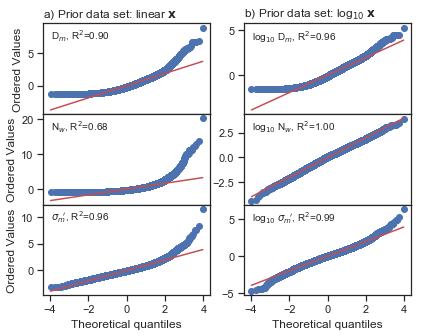

In [148]:
ncols = 2
fig, sps = plt.subplots(figsize=(6.6, 5), nrows=3, ncols=ncols, sharex=True)

sps = sps.reshape((3, ncols))

jj = 0

for kk in range(3):
    for ii, (x_name, x_vars) in enumerate([
        ('linear', ['Dm', 'Nw', 'Smprime']),
        ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
    ]):

        x_var = x_vars[kk]
        data = (rainDat_training[x_var] - np.mean(rainDat_training[x_var])) / np.std(rainDat_training[x_var] )
        (osm, osr), (slope, intercept, r) = stats.probplot(
            data,
            dist="norm",
            plot=sps[kk, ii],
            fit=True,
            rvalue=False)

        sps[kk, ii].set_title('')
        if kk == 0:
            sps[kk, ii].set_title('%s) Prior data set: %s $\mathbf{x}$'%(abc[ii], x_name), loc='left')


        sps[kk, ii].text(
            0.05,
            0.95,
            '%s, R$^2$=%.2f' % (
                supporting_routines.niceKeys[x_var], r**2
                #, x_mean, x_std
            ),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[kk, ii].transAxes)

        if kk < 2:
            sps[kk, ii].set_xlabel("")
        if ii > 0:
            sps[kk, ii].set_ylabel("")
        jj += 1

fig.subplots_adjust(hspace=0)
# fig.savefig('Figure4.1.pdf')

The prior $\mathbf{x}_{a}$ and covariance **S**$_a$ of the state vector are estimated from the training data set. For convenience, we estimate it for the linear and logarithmic variables together and select the required quantities later. 

In [8]:
S_a = rainDat_training.to_dataframe().cov()
x_ap = rainDat_training.to_dataframe().mean()
print(x_ap)
print(S_a)

Dm                  1.461640
Nw               4054.575495
Smprime             0.299574
Nw_log10            3.436274
Dm_log10            0.153298
Smprime_log10      -0.530466
dtype: float64
                       Dm            Nw    Smprime     Nw_log10    Dm_log10  \
Dm               0.128514 -4.313570e+02  -0.000075    -0.055004    0.034559   
Nw            -431.356978  1.825811e+07 -32.369253  1364.035418 -124.718395   
Smprime         -0.000075 -3.236925e+01   0.002993    -0.002567    0.000055   
Nw_log10        -0.055004  1.364035e+03  -0.002567     0.157103   -0.015119   
Dm_log10         0.034559 -1.247184e+02   0.000055    -0.015119    0.009550   
Smprime_log10    0.000101 -4.948687e+01   0.004192    -0.003630    0.000150   

               Smprime_log10  
Dm                  0.000101  
Nw                -49.486873  
Smprime             0.004192  
Nw_log10           -0.003630  
Dm_log10            0.000150  
Smprime_log10       0.006027  


When estimating the prior, the use of SI units is not always recommended: Combining small and large quantities with different units (e.g. temperature in K and specific humidity in kg/kg), the prior can be singular prohibiting an efficient use. **S**$_a$ is visualized

## Measurement space

The measurement vector $\mathbf{y}$ consists of the radar reflectivity factor ($Z$) and the mean Doppler velocity ($V_d$) at 13.6 GHz and 35.5 GHz. Even though we use only 35.5 GHz in the following, we encourage the reader to experiment with different $\mathbf{y}$ combinations. For  **S**$_y$, we assume that the uncertainties of  $Z$ and $V_d$ are 1 dB and 0.3 m s$^{-1}$, respectively, and that the errors are not correlated. Even though these error estimates are generally realistic, the values should be carefully evaluated for a real world application.

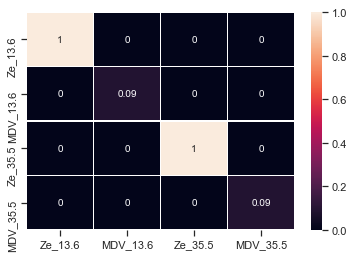

In [9]:
y_vars = ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]
y_noise = np.array([1, .3, 1, .3])
S_y = pn.DataFrame(
    np.diag(y_noise**2),
    index=y_vars,
    columns=y_vars,
)
sns.heatmap(S_y, annot=True, fmt='g', linewidths=.05)

## Forward operator
To prepare the retrieval, we set up PAMTRA2 properly and create dictionaries to store the results.

In [10]:
pam2Prepared = supporting_routines.preparePamtra(frequencies=[13.6e9, 35.5e9])


Did not find information about relativePermittivityIce. This might cause trouble later.


/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:170: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.arccos((cos_sca-cos_th*cos_inc)/(sin_th*sin_inc))
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:171: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.arccos((cos_inc-cos_th*cos_sca)/(sin_th*sin_sca))


The message about `relativePermittivityIce` can be ignored. After this the forward operator can be run with `supporting_routines.forwardPamtra`.  In short, the forward operator accepts $\mathbf{x}$ as an input argument and returns $\mathbf{y}$. In addition, `pam2Prepared` (prepared above) and the list of $\mathbf{y}$ elements to be returned needs to be provided. See `libs/supporting_routines.py` for details.

# Example retrieval

First, we need names for the elements of $\mathbf{x}$  and $\mathbf{y}$ 

In [11]:
x_vars = ['Dm', 'Nw', 'Smprime']
y_vars = ["Ze_13.6", "MDV_13.6"]

Additional  variables required for the forward operator

In [12]:
forwardKwArgs = {'pam2': pam2Prepared, 'y_vars': y_vars}

We use the 51st profile from the test data set as $\mathbf{x}_{truth}$

In [13]:
tt = 51
x_truth = rainDat_test[x_vars].to_dataframe().iloc[tt]

In [13]:
tt = np.argmin(np.abs(rainDat_test['Dm'] - 1.202))
rainDat_test.isel(time=tt), tt

(<xarray.Dataset>
 Dimensions:        ()
 Coordinates:
     time           datetime64[ns] 2010-01-17T08:15:00
 Data variables:
     Dm             float64 1.202
     Nw             float64 5.823e+03
     Smprime        float64 0.4368
     Nw_log10       float64 3.765
     Dm_log10       float64 0.07995
     Smprime_log10  float64 -0.3597, <xarray.DataArray 'Dm' ()>
 array(51))

For simplicity, we use a synthetic observations, i.e. we use PAMTRA2 to simulate an observation based on a known atmospheric state $\mathbf{x}_{truth}$. Even though $\mathbf{x}_{truth}$ is typically unknown in a real-world example, the use of synthetic observations is extremely helpful for assessing retrieval performance by comparing $\mathbf{x}_{op}$ to $\mathbf{x}_{truth}$. The `**forwardKwArgs` passes all dictionary values of `forwardKwArgs` as named function arguments (see https://www.geeksforgeeks.org/args-kwargs-python/).

In [14]:
y_obs = supporting_routines.forwardPamtra(
    x_truth,
    **forwardKwArgs,
)
y_obs

Ze_13.6     29.756770
MDV_13.6     6.194538
dtype: float64

`pyOptimalEstimation` uses objects. Therefore, we combine all information for the reference run into an object which we name `oe` 

In [15]:
# create optimal estimation object
oe = pyOE.optimalEstimation(
    x_vars,  # state variable names
    x_ap[x_vars],  # a priori
    S_a[x_vars].loc[x_vars],  # a priori uncertainty
    y_vars,  # measurement variable names
    y_obs,  # observations
    S_y[y_vars].loc[y_vars],  # observation uncertainty
    supporting_routines.forwardPamtra,  # forward Operator
    forwardKwArgs=forwardKwArgs,  # additonal function arguments
)

Store true profile in `oe` object. This is just for convenience, it is not
used by the retrieval.

In [16]:
oe.x_truth = x_truth

Do the retrieval with max. 10 iterations.

In [17]:
converged = oe.doRetrieval(maxIter=10)

0.46 s, iteration 1, degrees of freedom: 1.92 of 3. convergence criteria NOT fullfilled  1.375
0.68 s, iteration 2, degrees of freedom: 1.91 of 3. convergence criteria fullfilled  0.001
0.92 s, iteration 3, degrees of freedom: 1.91 of 3.  Done.  0.000


It converges after 2 iterations. 1.91 degrees of freedom for signal $d$ (the number of independent information pieces) are retrieved which is shows the good performance of the retrieval given that the maximum $d$ value is 2 because $\mathbf{y} consists of 2 measurements. 

After convergence, the solution $\mathbf{x}_{op}$ and the retrieved uncertainty **S**$_{op}$ is available with

In [18]:
print(oe.x_op)
print(oe.S_op)

Dm            1.444864
Nw         2102.003124
Smprime       0.306848
dtype: float64
                 Dm            Nw    Smprime
Dm         0.016757 -1.698757e+02  -0.004985
Nw      -169.875723  2.066878e+06  42.193265
Smprime   -0.004985  4.219327e+01   0.002522


pyOptimalEstimation uses Pandas objects not only for the input, but also for the output to make sure the elements of $\mathbf{x}$ and $\mathbf{y}$ are nit mixed up.

For convenience, the one sigma uncertainties derived from **S**$_{op}$ are also available

In [19]:
print(oe.x_op_err)

Dm            0.129451
Nw         1437.664246
Smprime       0.050219
dtype: float64


$d$ is available as a total as well as per $\mathbf{x}$ variable

In [20]:
print('total', oe.dgf)
print(oe.dgf_x)

total 1.9093322923665519
Dm         0.904881
Nw         0.881159
Smprime    0.123292
dtype: float64


We recommend to apply various statistical tests to the result with the `chiSquareTest()` function. The tests include:

1. $\mathbf{y}_{op}$  agrees with the measurement $\mathbf{y}_{obs}$ (`Y_Optimal_vs_Observation`, Rodgers, 2000, Sec. 12.3.2) 
2. the observation $\mathbf{y}_{obs}$ agrees with the prior $\mathbb{S}_a$ (`Y_Observation_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.1) 
3. the retrieved measurement agrees with the prior $\mathbb{S}_a$ (`Y_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.3) 
4. the retrieved state $\mathbf{x}_{op}$ agrees with the prior $\mathbb{S}_a$ (`X_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.2) 



In [21]:
print(oe.chiSquareTest()[0])

Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


Finally, we test with `testLinearity()`  whether the forward operator is moderately linear following chapter 5.1 of Rodgers 2000. The analysis for this example is based on $\mathbf{x}_{truth}$. The $\chi^2$ value (`trueLinearityChi2`) corresponding to the model beeing moderately linear must be smaller than the critical value (`trueLinearityChi2Crit`).

The first returned element is a boolean indicating whether the $\chi^2$ tests were successful: 

In [22]:
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe.linearityTest(significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)

Linearity test passed:  False


The fact that this test fails indicates already that the retrieval with linear $\mathbf{x}$ variables does not work (see below)

When running several retrievals, we recommend using the `oe.summarize` function which summarizes all retrieval results in an Xarray Dataset (which is structured similar to a netCDF file):

In [23]:
oe.summarize(returnXarray=True)

<xarray.Dataset>
Dimensions:                    (chi2test: 4, x_vars: 3, x_vars_T: 3, y_vars: 2, y_vars_T: 2)
Coordinates:
  * x_vars                     (x_vars) object 'Dm' 'Nw' 'Smprime'
  * x_vars_T                   (x_vars_T) object 'Dm' 'Nw' 'Smprime'
  * y_vars                     (y_vars) object 'Ze_13.6' 'MDV_13.6'
  * y_vars_T                   (y_vars_T) object 'Ze_13.6' 'MDV_13.6'
  * chi2test                   (chi2test) object 'Y_Optimal_vs_Observation' ... 'X_Optimal_vs_Prior'
Data variables:
    x_a                        (x_vars) float64 1.462 4.055e+03 0.2996
    x_a_err                    (x_vars) float64 0.3585 4.273e+03 0.05471
    S_a                        (x_vars, x_vars_T) float64 0.1285 ... 0.002993
    x_op                       (x_vars) float64 1.445 2.102e+03 0.3068
    x_op_err                   (x_vars) float64 0.1295 1.438e+03 0.05022
    S_op                       (x_vars, x_vars_T) float64 0.01676 ... 0.002522
    dgf_x                      (x_vars) f

# Run retrieval

After we presented the retrieval step-by-step, we integrate everything into a loop to apply the retrieval to all 100 profiles. 

The results are saved in dictionaries:

In [24]:
resultsOE = {}
failed = {}

To compare performance, we run the retrieval in two configurations:

1. linear state variables (see the step-by-step example above)
2. logarithmic state variables


In [26]:
#     name, [X_variables],
x_names = dict([
    ('Linear', ['Dm', 'Nw', 'Smprime']),
    ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
])

In this study, we use only a measurement configuration consisting of a radar reflectivity ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$). But the example is designed to work also with dual-frequency set ups and we encourage the reader to experiment  with different configurations. 


In [27]:
#     name, [Y_variables],
y_names = dict([
    ('Z', ["Ze_13.6"]),
    ('ZW', ["Ze_13.6", "MDV_13.6"]),
    ('Zdual', ["Ze_13.6", "Ze_35.5"]),
    ('ZWdual', ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]),
])

In [108]:
for x_name, y_name in (
    ('Linear', 'ZW',),
    ('log$_{10}$', 'ZW'),
):

    x_vars = x_names[x_name]
    y_vars = y_names[y_name]

    resultsOE['%s %s' % (x_name, y_name)] = []
    failed['%s %s' % (x_name, y_name)] = []

    #Additional required variables for the forward operator
    forwardKwArgs = {'pam2': pam2Prepared, 'y_vars': y_vars}

    print('#' * 80)
    print(x_name, y_name)
    print('#' * 80)

#     for tt in [15, 20, 51]:
    for tt in range(rainDat_test[x_vars].time.shape[0]):

        x_truth = rainDat_test[x_vars].to_dataframe().iloc[tt]
        # simulate observation based on true state x_truth
        y_obs = supporting_routines.forwardPamtra(
            x_truth,
            pam2=pam2Prepared,
            y_vars=y_vars,
        )

        # create optimal estimation object
        oe = pyOE.optimalEstimation(
            x_vars,  # state variable names
            x_ap[x_vars],  # a priori
            S_a[x_vars].loc[x_vars],  # a priori uncertainty
            y_vars,  # measurement variable names
            y_obs,  # observations
            S_y[y_vars].loc[y_vars],  # observation uncertainty
            supporting_routines.forwardPamtra,  # forward Operator
            forwardKwArgs=forwardKwArgs,  # additonal function arguments
        )

        # Store true profile in `oe` object. This is just for convenience, it is not
        # used by the retrieval.
        oe.x_truth = x_truth

        # Do the retrieval with max. 10 iterations.
        converged = oe.doRetrieval(maxIter=10)

        if converged:

            # Test whethe rthe retrieval is moderately lienar around x_truth
            print(oe.linearityTest())

            # Show hdegrees of freedom per variable
            print(oe.dgf_x)

            # Apply chi2 tests for retrieval quality
            print(oe.chiSquareTest())

            if x_name.startswith('log'):
                # Show RMS normalized with prior
                print('RMS log', np.sqrt(
                    np.mean(((10**oe.x_truth - 10**oe.x_op) / 10**oe.x_a)**2)))
                print('truth', 10**oe.x_truth)
                print('op', 10**unp.uarray(oe.x_op.values,
                                         oe.x_op_err.values))
            else:
                # Show RMS normalized with prior
                print('RMS', np.sqrt(
                    np.mean(((oe.x_truth - oe.x_op) / oe.x_a)**2)))
                print('truth', oe.x_truth)
                print('op', unp.uarray(oe.x_op.values,
                                         oe.x_op_err.values))
                
            #Store results in xarray DataArray
            summary = oe.summarize(returnXarray=True)
            summary['time'] = rainDat_test[x_vars].time[tt]
            
            resultsOE['%s %s' % (x_name, y_name)].append(summary)
        else:
            failed['%s %s' % (x_name, y_name)].append(tt)
            
            
    #Store results in xarray Dataset structure for later analysis.
    resultsOE['%s %s' % (x_name, y_name)] = xr.concat(
        resultsOE['%s %s' % (x_name, y_name)],
        dim='time')
    

################################################################################
Linear ZW
################################################################################
0.28 s, iteration 1, degrees of freedom: 1.77 of 3. convergence criteria fullfilled  0.017
0.42 s, iteration 2, degrees of freedom: 1.77 of 3.  Done.  0.000
([1.31664499661615, 0.00067507598515647, 0.0005244346764850746], array(0.06722079), 5.991464547107983)
Dm         0.967234
Nw         0.610596
Smprime    0.196107
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.170134
Y_Observation_vs_Prior      0.163760
Y_Optimal_vs_Prior          0.166656
X_Optimal_vs_Prior          0.161910
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observa

0.30 s, iteration 1, degrees of freedom: 1.94 of 3. convergence criteria NOT fullfilled  3.753
0.45 s, iteration 2, degrees of freedom: 1.92 of 3. convergence criteria fullfilled  0.001
0.58 s, iteration 3, degrees of freedom: 1.92 of 3.  Done.  0.000
([6.796875046063077, 0.0013430031961420253, 0.0001778116391400857], array(0.04821977), 5.991464547107983)
Dm         0.902085
Nw         0.908848
Smprime    0.111050
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.439910
Y_Observation_vs_Prior      0.208485
Y_Optimal_vs_Prior          0.204488
X_Optimal_vs_Prior          0.364131
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 3
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 3
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 3
0.78 s, iteration 3, degrees of freedom: 0.92 of 3. convergence criteria NOT fullfilled  12.487
0.90 s, iteration 4, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  21.959
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 5
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 5
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 5
1.04 s, iteration 5, degrees of freedom: 0.92 of 3. convergence criteria NOT fullfil

0.30 s, iteration 1, degrees of freedom: 1.58 of 3. convergence criteria NOT fullfilled  1.564
0.44 s, iteration 2, degrees of freedom: 1.57 of 3. convergence criteria fullfilled  0.001
0.58 s, iteration 3, degrees of freedom: 1.57 of 3.  Done.  0.000
([0.3546596584736829, 0.0020852986261470485, 0.0005887686627420751], array(0.12157071), 5.991464547107983)
Dm         0.998970
Nw         0.366478
Smprime    0.208234
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.180321
Y_Observation_vs_Prior      3.373178
Y_Optimal_vs_Prior          4.526723
X_Optimal_vs_Prior          2.166830
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optima

0.26 s, iteration 1, degrees of freedom: 1.59 of 3. convergence criteria NOT fullfilled  1.591
0.44 s, iteration 2, degrees of freedom: 1.57 of 3. convergence criteria fullfilled  0.001
0.59 s, iteration 3, degrees of freedom: 1.58 of 3.  Done.  0.000
([0.41728084367070545, 0.0021004997596182386, 0.00040872328086154187], array(0.01534852), 5.991464547107983)
Dm         0.999688
Nw         0.385206
Smprime    0.192780
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.987335
Y_Observation_vs_Prior      3.050674
Y_Optimal_vs_Prior          4.150949
X_Optimal_vs_Prior          1.984723
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Opti

0.55 s, iteration 3, degrees of freedom: 1.93 of 3.  Done.  0.000
([7.151054922992921, 0.0012067786632734773, 0.000230901723607233], array(0.00863263), 5.991464547107983)
Dm         0.904126
Nw         0.917075
Smprime    0.104976
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.559627
Y_Observation_vs_Prior      0.246278
Y_Optimal_vs_Prior          0.242521
X_Optimal_vs_Prior          0.432592
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.10552805667897303
truth Dm            1.328618
Nw         2212.321436
Smprime       0.342147
Name: 2011-09-04 18:45:0

Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.635427
Y_Observation_vs_Prior      1.990519
Y_Optimal_vs_Prior          2.497897
X_Optimal_vs_Prior          1.638477
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.20994720118355747
truth Dm            1.083100
Nw         4980.495540
Smprime       0.214945
Name: 2011-03-28 04:30:00, dtype: float64
op [1.0365903052032739+/-0.07399364578906341
 6115.305361277164+/-2970.8943932924494
 0.28383758458335534+/-0.04888831921922241]
0.33 s, iteration 1, degrees of freedom: 1.86 of 3. convergence criteria NOT fullfilled  2.444
0.45

0.27 s, iteration 1, degrees of freedom: 1.63 of 3. convergence criteria NOT fullfilled  0.934
0.40 s, iteration 2, degrees of freedom: 1.64 of 3. convergence criteria fullfilled  0.001
0.52 s, iteration 3, degrees of freedom: 1.64 of 3.  Done.  0.000
([0.3684173407598852, 0.0007103038226601028, 0.0005534448275347383], array(0.01871595), 5.991464547107983)
Dm         0.985938
Nw         0.377485
Smprime    0.273536
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.771415
Y_Observation_vs_Prior      2.454193
Y_Optimal_vs_Prior          2.865175
X_Optimal_vs_Prior          1.797970
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optima

0.24 s, iteration 1, degrees of freedom: 1.94 of 3. convergence criteria NOT fullfilled  20.419
0.36 s, iteration 2, degrees of freedom: 1.92 of 3. convergence criteria fullfilled  0.134
0.56 s, iteration 3, degrees of freedom: 1.92 of 3.  Done.  0.002
([11.117876037445187, 0.002093730009534489, 3.287161271695937e-05], array(7.8844086e-05), 5.991464547107983)
Dm         0.856976
Nw         0.938057
Smprime    0.124884
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.956954
Y_Observation_vs_Prior      0.316433
Y_Optimal_vs_Prior          0.311305
X_Optimal_vs_Prior          0.473437
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Opt

0.23 s, iteration 1, degrees of freedom: 1.82 of 3. convergence criteria NOT fullfilled  0.251
0.34 s, iteration 2, degrees of freedom: 1.81 of 3. convergence criteria fullfilled  0.000
0.48 s, iteration 3, degrees of freedom: 1.81 of 3.  Done.  0.000
([3.8324176856113383, 0.002174020597724608, 0.00012503184861147325], array(4.77422822e-05), 5.991464547107983)
Dm         0.881321
Nw         0.738044
Smprime    0.193023
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.736049
Y_Observation_vs_Prior      0.998617
Y_Optimal_vs_Prior          1.031256
X_Optimal_vs_Prior          0.738306
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Op

1.06 s, iteration 6, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  50.300
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 7
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 7
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 7
1.21 s, iteration 7, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfilled  2.346
1.34 s, iteration 8, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  50.300
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 9
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 9
############################################################
reset due to nan: Smprime from nan to 0.299574 in i

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 9
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 9
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 9
2.03 s, iteration 9, degrees of freedom: 0.88 of 3. convergence criteria NOT fullfilled  17.398
0.47 s, iteration 1, degrees of freedom: 1.71 of 3. convergence criteria NOT fullfilled  0.296
0.59 s, iteration 2, degrees of freedom: 1.71 of 3. convergence criteria fullfilled  0.001
0.73 s, iteration 3, degrees of freedom: 1.71 of 3.  Done.  0.000
([1.2769681275896212, 0.0020119118769269164, 7.357054934855115e-05], array(0.00036593), 5.991464547107983)
Dm         0.931910
Nw         0.523132
Smprime    0.256577
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Opt

0.25 s, iteration 1, degrees of freedom: 1.86 of 3. convergence criteria NOT fullfilled  0.262
0.36 s, iteration 2, degrees of freedom: 1.86 of 3. convergence criteria fullfilled  0.000
0.48 s, iteration 3, degrees of freedom: 1.86 of 3.  Done.  0.000
([2.8912802618587685, 0.000592908945074504, 0.0005133379125155523], array(0.46863319), 5.991464547107983)
Dm         0.951447
Nw         0.777726
Smprime    0.130018
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.468216
Y_Observation_vs_Prior      0.431839
Y_Optimal_vs_Prior          0.431188
X_Optimal_vs_Prior          0.470066
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal

0.23 s, iteration 1, degrees of freedom: 1.91 of 3. convergence criteria NOT fullfilled  1.493
0.39 s, iteration 2, degrees of freedom: 1.89 of 3. convergence criteria fullfilled  0.001
0.55 s, iteration 3, degrees of freedom: 1.89 of 3.  Done.  0.000
([6.673431761007953, 0.0021358416702250234, 3.7978572969441594e-05], array(0.22375304), 5.991464547107983)
Dm         0.873064
Nw         0.874165
Smprime    0.144974
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.367494
Y_Observation_vs_Prior      0.355320
Y_Optimal_vs_Prior          0.352513
X_Optimal_vs_Prior          0.366175
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optima

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 7
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 7
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 7
1.00 s, iteration 7, degrees of freedom: 0.94 of 3. convergence criteria NOT fullfilled  3.001
1.12 s, iteration 8, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  9.178
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 9
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 9
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 9
1.26 s, iteration 9, degrees of freedom: 0.94 of 3. convergence criteria NOT fullfille

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 9
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 9
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 9
1.47 s, iteration 9, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfilled  2.886
0.29 s, iteration 1, degrees of freedom: 1.80 of 3. convergence criteria fullfilled  0.195
0.41 s, iteration 2, degrees of freedom: 1.80 of 3.  Done.  0.000
([1.7877807646111354, 0.0010204157887481794, 0.0006531290931720097], array(6.78851106e-05), 5.991464547107983)
Dm         0.970367
Nw         0.674172
Smprime    0.151882
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          Tru

0.25 s, iteration 1, degrees of freedom: 1.86 of 3. convergence criteria fullfilled  0.106
0.38 s, iteration 2, degrees of freedom: 1.86 of 3.  Done.  0.000
([2.9065682272585645, 0.0008054813807578403, 0.00042920008298561244], array(0.06464512), 5.991464547107983)
Dm         0.943488
Nw         0.775993
Smprime    0.142247
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.274331
Y_Observation_vs_Prior      0.225216
Y_Optimal_vs_Prior          0.224453
X_Optimal_vs_Prior          0.240350
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.13254177971755804
truth

0.24 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria NOT fullfilled  0.535
0.39 s, iteration 2, degrees of freedom: 1.77 of 3. convergence criteria fullfilled  0.000
0.56 s, iteration 3, degrees of freedom: 1.77 of 3.  Done.  0.000
([1.665003636338896, 0.0014661479051600297, 0.0005128406660522906], array(0.00165765), 5.991464547107983)
Dm         0.978511
Nw         0.648268
Smprime    0.142949
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.929382
Y_Observation_vs_Prior      0.855314
Y_Optimal_vs_Prior          0.870602
X_Optimal_vs_Prior          0.922966
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal

0.26 s, iteration 1, degrees of freedom: 1.77 of 3. convergence criteria fullfilled  0.022
0.46 s, iteration 2, degrees of freedom: 1.77 of 3.  Done.  0.000
([0.011114417742051805, 0.0003351272303601207, 0.00018591024032540553], array(0.00062425), 5.991464547107983)
Dm_log10         0.952186
Nw_log10         0.657173
Smprime_log10    0.159014
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.311886
Y_Observation_vs_Prior      0.332396
Y_Optimal_vs_Prior          0.335268
X_Optimal_vs_Prior          0.306101
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.34 s, iteration 1, degrees of freedom: 1.76 of 3. convergence criteria fullfilled  0.146
0.48 s, iteration 2, degrees of freedom: 1.76 of 3.  Done.  0.000
([0.0015648938303516706, 0.001068584702424289, 0.00013206207062097503], array(0.07348296), 5.991464547107983)
Dm_log10         0.934832
Nw_log10         0.571346
Smprime_log10    0.255673
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    4.256858
Y_Observation_vs_Prior      4.645556
Y_Optimal_vs_Prior          4.767908
X_Optimal_vs_Prior          4.129899
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.25 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.000
0.80 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.005461238909745071, 0.0009404709960689045, 4.621902221230017e-05], array(0.04556215), 5.991464547107983)
Dm_log10         0.950067
Nw_log10         0.634591
Smprime_log10    0.195842
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.245076
Y_Observation_vs_Prior      0.237423
Y_Optimal_vs_Prior          0.236243
X_Optimal_vs_Prior          0.244927
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.

0.63 s, iteration 1, degrees of freedom: 1.76 of 3. convergence criteria fullfilled  0.069
1.20 s, iteration 2, degrees of freedom: 1.76 of 3.  Done.  0.000
([0.011679715233555151, 0.00027553521643898895, 0.0001742903659770198], array(0.02662787), 5.991464547107983)
Dm_log10         0.950469
Nw_log10         0.652913
Smprime_log10    0.156237
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.279594
Y_Observation_vs_Prior      1.294188
Y_Optimal_vs_Prior          1.288181
X_Optimal_vs_Prior          1.249686
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.24 s, iteration 1, degrees of freedom: 1.74 of 3. convergence criteria fullfilled  0.199
0.51 s, iteration 2, degrees of freedom: 1.74 of 3.  Done.  0.000
([0.011541520729809943, 0.00016437809143843518, 0.00013129688469787763], array(0.00916466), 5.991464547107983)
Dm_log10         0.953113
Nw_log10         0.659191
Smprime_log10    0.126779
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.218600
Y_Observation_vs_Prior      1.493081
Y_Optimal_vs_Prior          1.567889
X_Optimal_vs_Prior          1.212744
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 

0.25 s, iteration 1, degrees of freedom: 1.77 of 3. convergence criteria fullfilled  0.024
0.37 s, iteration 2, degrees of freedom: 1.77 of 3.  Done.  0.000
([0.011148086932568423, 0.00030958001932755556, 0.00018290118461992537], array(0.00022382), 5.991464547107983)
Dm_log10         0.953516
Nw_log10         0.660283
Smprime_log10    0.152548
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.525038
Y_Observation_vs_Prior      0.561526
Y_Optimal_vs_Prior          0.570372
X_Optimal_vs_Prior          0.522952
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 

0.51 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.010
0.64 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.010443280398438892, 0.00043548558806660463, 0.00018665765412769614], array(0.0057184), 5.991464547107983)
Dm_log10         0.950397
Nw_log10         0.652506
Smprime_log10    0.173099
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.569419
Y_Observation_vs_Prior      0.573856
Y_Optimal_vs_Prior          0.572842
X_Optimal_vs_Prior          0.563912
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.61 s, iteration 1, degrees of freedom: 1.75 of 3. convergence criteria fullfilled  0.051
0.75 s, iteration 2, degrees of freedom: 1.75 of 3.  Done.  0.000
([0.002391061339912991, 0.0007744518447768319, 0.00010526381331177582], array(0.00013828), 5.991464547107983)
Dm_log10         0.945225
Nw_log10         0.590175
Smprime_log10    0.212826
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.271632
Y_Observation_vs_Prior      1.337151
Y_Optimal_vs_Prior          1.362396
X_Optimal_vs_Prior          1.273791
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.25 s, iteration 1, degrees of freedom: 1.76 of 3. convergence criteria fullfilled  0.012
0.37 s, iteration 2, degrees of freedom: 1.76 of 3.  Done.  0.000
([0.004171786781743151, 0.0008080911263405496, 4.6821156741153745e-05], array(5.1453483e-05), 5.991464547107983)
Dm_log10         0.951950
Nw_log10         0.622504
Smprime_log10    0.187743
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.486256
Y_Observation_vs_Prior      2.333649
Y_Optimal_vs_Prior          2.297551
X_Optimal_vs_Prior          2.479113
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS lo

Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool, chi2test
Y_Optimal_vs_Observation     7.870329
Y_Observation_vs_Prior      15.255963
Y_Optimal_vs_Prior          19.120272
X_Optimal_vs_Prior           7.700795
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.17061149091919517
truth Dm_log10           2.633944
Nw_log10         363.037550
Smprime_log10      0.382586
Name: 2011-03-30 05:32:00, dtype: float64
op [2.324686662563297+/-0.22750487373952627
 881.3721046809209+/-565.1803537304661
 0.3637481523325445+/-0.05625687636741121]
0.34 s, iteration 1, degrees of freedom: 1.77 of 3. convergence criteria fu

0.28 s, iteration 1, degrees of freedom: 1.75 of 3. convergence criteria NOT fullfilled  0.226
0.39 s, iteration 2, degrees of freedom: 1.74 of 3. convergence criteria fullfilled  0.000
0.51 s, iteration 3, degrees of freedom: 1.74 of 3.  Done.  0.000
([0.01138433534803441, 0.00019138176243903225, 0.000123249716025358], array(4.27847836e-07), 5.991464547107983)
Dm_log10         0.949973
Nw_log10         0.649631
Smprime_log10    0.140108
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.208505
Y_Observation_vs_Prior      2.327612
Y_Optimal_vs_Prior          2.318051
X_Optimal_vs_Prior          2.208095
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior    

0.31 s, iteration 1, degrees of freedom: 1.79 of 3. convergence criteria fullfilled  0.003
0.68 s, iteration 2, degrees of freedom: 1.79 of 3.  Done.  0.000
([0.004669685953123593, 0.0011999495760242319, 4.10670284369657e-05], array(0.22906295), 5.991464547107983)
Dm_log10         0.945373
Nw_log10         0.624193
Smprime_log10    0.218633
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.650122
Y_Observation_vs_Prior      0.645051
Y_Optimal_vs_Prior          0.643749
X_Optimal_vs_Prior          0.647016
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.2

0.26 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.044
0.37 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.010666433920336648, 0.0004612337728527178, 0.00020043174259757536], array(0.00225183), 5.991464547107983)
Dm_log10         0.945356
Nw_log10         0.640628
Smprime_log10    0.191276
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool, chi2test
Y_Optimal_vs_Observation    6.201843
Y_Observation_vs_Prior      6.153664
Y_Optimal_vs_Prior          6.132109
X_Optimal_vs_Prior          6.169721
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS l

0.25 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.000
0.41 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.008000296725141316, 0.0006634412176653332, 0.00011529142527229243], array(0.00583841), 5.991464547107983)
Dm_log10         0.951622
Nw_log10         0.649656
Smprime_log10    0.181045
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.091491
Y_Observation_vs_Prior      0.091704
Y_Optimal_vs_Prior          0.091752
X_Optimal_vs_Prior          0.091548
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

# Analyze results


## Compare retrieval quality

Here we compare the retrieval quality by comparing the number of profiles that converged, passed the $\chi^2$-tests, and the linearity test:

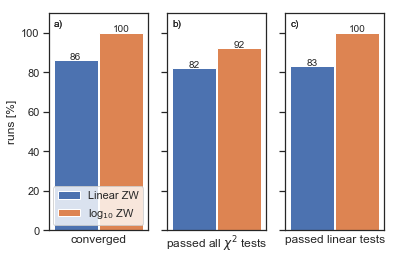

In [136]:
fig, sps = plt.subplots(ncols=3, sharey=True, figsize=(6, 4))

for kk, key in enumerate(resultsOE.keys()):

    converged = len(resultsOE[key].time)
    passedLinearity = (resultsOE[key].trueLinearityChi2 <
                       resultsOE[key].trueLinearityChi2Critical).sum().values
    passedChi2 = (resultsOE[key].chi2value <
                  resultsOE[key].chi2critical).all('chi2test').sum().values

    sps[0].bar(kk, converged, label=key, width=0.98)
    sps[1].bar(kk, passedChi2, label=key, width=0.98)
    sps[2].bar(kk, passedLinearity, label=key, width=0.98)

    sps[0].text(
        kk, converged + .25, str(converged), horizontalalignment='center')
    sps[1].text(
        kk, passedChi2 + .25, str(passedChi2), horizontalalignment='center')
    sps[2].text(
        kk,
        passedLinearity + .25,
        str(passedLinearity),
        horizontalalignment='center')

    sps[0].set_xticks([])
    sps[1].set_xticks([])
    sps[2].set_xticks([])
    sps[0].set_xlabel('converged')
    sps[2].set_xlabel('passed linear tests')
    sps[1].set_xlabel('passed all $\chi^2$ tests')

    sps[0].set_ylabel('runs [%]')
    sps[0].set_ylim(0, 110)
    sps[0].legend(loc='lower center')

    for ii in range(3):
        sps[ii].text(
            0.05,
            0.97,
            '%s)' % (abc[ii]),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[ii].transAxes)

Independently how performance is measured, the version with the logarithmic $\mathbf{x}$ variables performs better. It should be noted that applying a $\chi^2$ test with 5% confidence interval to a larger number of retrievals means that 5% of the profiles do not pass the test even though they are fine.

## Compare retrieval error distributions

Similar to the prior, we also compare the distributions of relative retrieval errors defined with

   \begin{equation}
   \frac{\mathbf{x}_{op} - \mathbf{x}_{truth}}{\sqrt{(\textrm{diag}( \mathsf{S}_y)}}
   \end{equation}

In theory, the relative retrieval errors should follow a normal distribution with mean 0 and standard deviation 1. 

Linear ZW Dm 0.07109275362752564 0.7016137474506298
Linear ZW Nw -0.2303709216476416 0.6794944463667899
Linear ZW Smprime 0.013061075538017695 0.8475918056208038
log$_{10}$ ZW Dm_log10 0.05943233533481208 0.8885066185052868
log$_{10}$ ZW Nw_log10 -0.049210718868360225 0.8247281075181255
log$_{10}$ ZW Smprime_log10 0.06880373828374176 0.9946721558115889


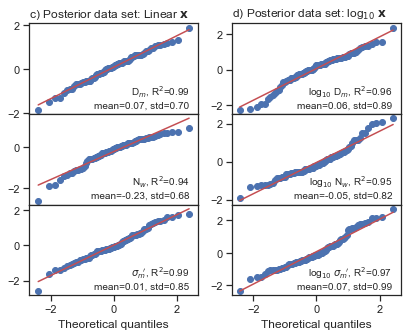

In [155]:
ncols = len(resultsOE.keys())
fig, sps = plt.subplots(
    figsize=(3.33 * ncols, 5), nrows=len(x_vars), ncols=ncols, sharex=True)

sps = sps.reshape((len(x_vars), ncols))

jj = 0

for yy, key in enumerate(resultsOE.keys()):

    for kk in range(3):

        x_var = resultsOE[key].x_vars.values[kk]
        thisOe = resultsOE[key].isel(x_vars=kk)
        passedChiTests = (thisOe.chi2value <=
                          thisOe.chi2critical).all('chi2test')
        thisOe = thisOe.where(passedChiTests).dropna('time')
        x_err = ((thisOe['x_op'] - thisOe['x_truth']) / thisOe['x_op_err'])

        x_mean = x_err.mean().values
        x_std = x_err.std().values

        print(key, x_var, x_mean, x_std)

        (osm, osr), (slope, intercept, r) = stats.probplot(
            x_err, dist="norm", plot=sps[kk, yy], fit=True, rvalue=False)

        sps[kk, yy].set_title('')
        if kk == 0:
            sps[kk, yy].set_title('%s) Posterior data set: %s $\mathbf{x}$'%(abc[yy+2], key.split(' ')[0]), loc='left')

        sps[kk, yy].text(
            0.95,
            0.05,
            '%s, R$^2$=%.2f\nmean=%.2f, std=%.2f' %
            (supporting_routines.niceKeys[x_var], r**2, x_mean, x_std),
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=sps[kk, yy].transAxes)


        if kk < 2:
            sps[kk, yy].set_xlabel("")
        sps[kk, yy].set_ylabel("")

        jj += 1

fig.subplots_adjust(hspace=0)
fig.savefig('Figure4.2.pdf')

With one exception, mean and standard deviation are closer to 0 and 1, respectively, for the logarithmic retrieval. In other words, non-normally distributed state variables lead to non-normally distributed retrieval error distributions. In these cases, the retrieval uncertainty cannot be correctly described with **S**$_{op}$. 

## Compare retrieval quality

<xarray.DataArray (time: 100, chi2test: 4)>
array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])
Coordinates:
  * chi2test  (chi2test) object 'Y_Optimal_vs_Observation' ... 'X_Optimal_vs_Prior'
  * time      (time) datetime64[ns] 2011-09-05T09:19:00 ... 2010-03-13T14:57:00

In [293]:
dat

x_vars,Dm_log10,Nw_log10,Smprime_log10
time,,,
2011-09-05 09:19:00,0.952942,0.656480,0.167053
2011-02-01 23:47:00,0.955553,0.663145,0.150268
2011-03-05 10:01:00,0.952250,0.656234,0.166329
2011-01-18 09:09:00,0.949465,0.649481,0.183071
2011-03-26 16:14:00,0.949704,0.649275,0.184353
2010-02-04 19:06:00,0.952186,0.657173,0.159014
2009-12-18 11:18:00,0.948898,0.639713,0.198624
2011-03-05 03:48:00,0.948102,0.639092,0.201922
2010-03-25 13:26:00,0.942341,0.577256,0.220202


Text(0.97, 0.97, 'b)')

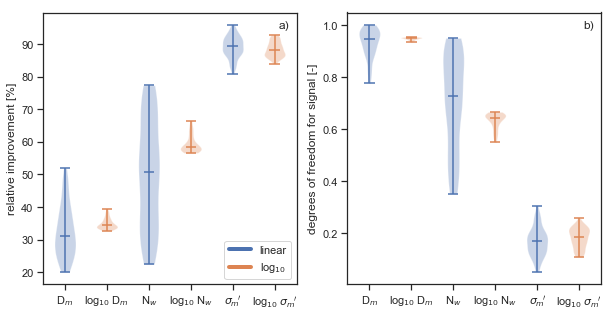

In [294]:

fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize=(10,5))
positions = np.array([0,2,4])
                     


for yy, key in enumerate(resultsOE.keys()):

    thisOE = resultsOE[key].where((resultsOE[key].chi2value < resultsOE[key].chi2critical).all('chi2test'))
    
    dat = (thisOE['x_op_err']/thisOE['x_a_err']).to_pandas().dropna() * 100
    ax1.violinplot(dat.T, positions = positions+yy, showmedians=True)


    dat = (thisOE['dgf_x']).to_pandas().dropna()
    ax2.violinplot(dat.T, positions = positions+yy, showmedians=True)
    
    
cols = ['Dm', 'Dm_log10', 'Nw', 'Nw_log10', 'Smprime', 'Smprime_log10']
labels = []
for tt in cols:
    labels.append(supporting_routines.niceKeys[tt])
ax2.set_xticks(range(6)) 
ax2.set_xticklabels(labels) 
ax1.set_xticks(range(6)) 
ax1.set_xticklabels(labels) 

ax1.set_ylabel('relative improvement [%]')
ax2.set_ylabel('degrees of freedom for signal [-]')

custom_lines = [matplotlib.lines.Line2D([0], [0], color='C0', lw=4),
                matplotlib.lines.Line2D([0], [0], color='C1', lw=4),
               ]

ax1.legend(custom_lines, ['linear', 'log$_{10}$'], loc='lower right')
ax1.text(0.97, 0.97, 'a)', horizontalalignment='right', verticalalignment='top', transform = ax1.transAxes)
ax2.text(0.97, 0.97, 'b)', horizontalalignment='right', verticalalignment='top', transform = ax2.transAxes)



# References

Mech, M., M. Maahn, S. Kneifel, D. Ori, E. Orlandi, P. Kollias, V. Schemann, and S. Crewell, 2020: PAMTRA 1.0: A Passive and Active Microwave radiative TRAnsfer tool for simulating radiometer and radar measurements of the cloudy atmosphere. Geosci. Model Dev., submitted.

Testud, J., S. Oury, R. A. Black, P. Amayenc, and X. Dou, 2001: The concept of normalized distribution to describe raindrop spectra: A tool for cloud physics and cloud remote sensing. *J. Appl. Meteorol.*, 40, 1118–1140, [https://doi.org/10.1175/1520-0450(2001)040<1118:TCONDT>2.0.CO;2](https://doi.org/10.1175/1520-0450(2001)040<1118:TCONDT>2.0.CO;2).

Williams, C. R., V. N. Bringi, L. D. Carey, V. Chandrasekar, P. N. Gatlin, Z. S. Haddad, R. Meneghini, S. Joseph Munchak, S. W. Nesbitt, W. A. Petersen, S. Tanelli, A. Tokay, A. Wilson, and D. B. Wolff, 2014: Describing the Shape of Raindrop Size Distributions Using Uncorrelated Raindrop Mass Spectrum Parameters. *J. Appl. Meteor. Climatol.*, 53, 1282–1296, https://doi.org/10.1175/JAMC-D-13-076.1.




# OLD CODE - ignore!

will be removed in final version

[Text(0, 0, 'D$_m$'),
 Text(0, 0, 'log$_{10}$ D$_m$'),
 Text(0, 0, 'N$_w$'),
 Text(0, 0, 'log$_{10}$ N$_w$'),
 Text(0, 0, "$\\sigma_m\\!'$"),
 Text(0, 0, "log$_{10}$ $\\sigma_m\\!'$")]

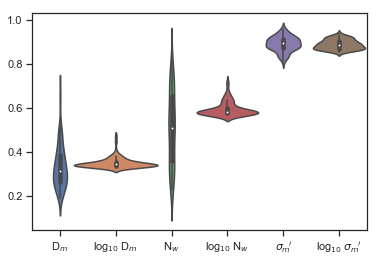

In [225]:
dats = []
for yy, key in enumerate(resultsOE.keys()):

    dat = (resultsOE[key]['x_op_err']/resultsOE[key]['x_a_err']).to_pandas()
    dats.append(dat)
dats = pn.merge(*dats, right_index=True, left_index=True)    
dats.columns.name = ''
cols = ['Dm', 'Dm_log10', 'Nw', 'Nw_log10', 'Smprime', 'Smprime_log10']
dats = dats[cols]
fig, ax = plt.subplots()

sns.violinplot(data=dats, scale='area', width=1.5, ax=ax)
labels = []
for tt in cols:
    labels.append(supporting_routines.niceKeys[tt])
ax.set_xticklabels(labels) 

ValueError: Invalid RGBA argument: ['#F0F000', '#F00000', '#F0F000', '#F00000', '#F0F000', '#F00000']

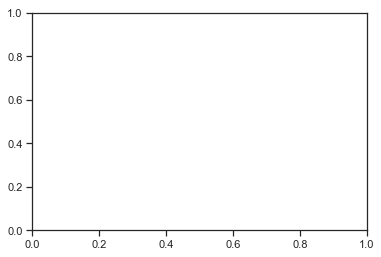

In [238]:
dats = []
for yy, key in enumerate(resultsOE.keys()):

    dat = (resultsOE[key]['dgf_x']).to_pandas()
    dats.append(dat)
dats = pn.merge(*dats, right_index=True, left_index=True)    
dats.columns.name = ''
cols = ['Dm', 'Dm_log10', 'Nw', 'Nw_log10', 'Smprime', 'Smprime_log10']
dats = dats[cols]
fig, ax = plt.subplots()
pal =["#F0F000","#F00000"]*3
sns.boxplot(data=dats, width=0.5, ax=ax, color=pal)
labels = []
for tt in cols:
    labels.append(supporting_routines.niceKeys[tt])
ax.set_xticklabels(labels) 

Text(0.97, 0.97, 'b)')

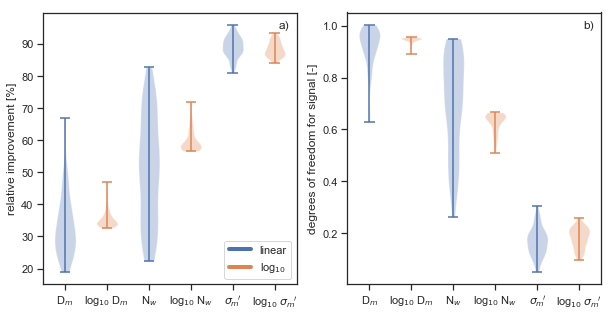

In [277]:

fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize=(10,5))
positions = np.array([0,2,4])
                     


for yy, key in enumerate(resultsOE.keys()):

    dat = (resultsOE[key]['x_op_err']/resultsOE[key]['x_a_err']).to_pandas() * 100
    ax1.violinplot(dat.T, positions = positions+yy)


    dat = (resultsOE[key]['dgf_x']).to_pandas()
    ax2.violinplot(dat.T, positions = positions+yy)
    
    
cols = ['Dm', 'Dm_log10', 'Nw', 'Nw_log10', 'Smprime', 'Smprime_log10']
labels = []
for tt in cols:
    labels.append(supporting_routines.niceKeys[tt])
ax2.set_xticks(range(6)) 
ax2.set_xticklabels(labels) 
ax1.set_xticks(range(6)) 
ax1.set_xticklabels(labels) 

ax1.set_ylabel('relative improvement [%]')
ax2.set_ylabel('degrees of freedom for signal [-]')

custom_lines = [matplotlib.lines.Line2D([0], [0], color='C0', lw=4),
                matplotlib.lines.Line2D([0], [0], color='C1', lw=4),
               ]

ax1.legend(custom_lines, ['linear', 'log$_{10}$'], loc='lower right')
ax1.text(0.97, 0.97, 'a)', horizontalalignment='right', verticalalignment='top', transform = ax1.transAxes)
ax2.text(0.97, 0.97, 'b)', horizontalalignment='right', verticalalignment='top', transform = ax2.transAxes)


In [248]:
positions

array([0, 2, 4])

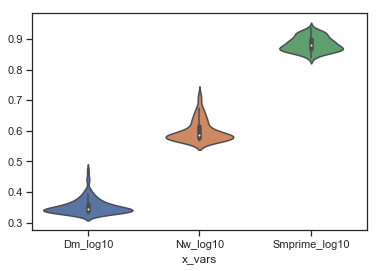

In [175]:
plt.figure()
dat = (resultsOE[key]['x_op_err']/resultsOE[key]['x_a_err']).to_pandas()
sns.violinplot(data=dat, xdata='x_vars')

In [ ]:
raise ValueError

In [157]:
resultsOEMerged = {}
for key in resultsOE.keys():
    if key.startswith('Linear '):
        resultsOEMerged[key] = resultsOE[key]
    elif key.startswith('log$_{10}$ '):
        assert resultsOE[key].x_vars[0] == 'Dm_log10'
        assert resultsOE[key].x_vars[2] == 'Smprime_log10'
        
        linState = {}
        linState['x_truth'] = 10**resultsOE[key].x_truth
        x_op = 10**unp.uarray(resultsOE[key].x_op.values,
                                     resultsOE[key].x_op_err.values)
        x_a = 10**unp.uarray(resultsOE[key].x_a.values,
                                     resultsOE[key].x_a_err.values)

        linState['x_op_err'] = xr.zeros_like(
            linState['x_truth']) + unp.std_devs(x_op)
        linState['x_op'] = xr.zeros_like(
            linState['x_truth']) + unp.nominal_values(x_op)
        linState['x_a_err'] = xr.zeros_like(
            linState['x_truth']) + unp.std_devs(x_a)
        linState['x_a'] = xr.zeros_like(
            linState['x_truth']) + unp.nominal_values(x_a)
        linState['dgf_x'] = resultsOE[key]['dgf_x']

        linState = xr.Dataset(linState)
#         linState = linState.rename({'variable':'x_vars'})
        linState['x_vars'] = ['Dm', 'Nw', 'Smprime']
        resultsOEMerged[key] = xr.merge((resultsOE[key],linState))

#     elif key.startswith('log$_{10}$ with $\\sigma_m\\!$_'):
#         assert resultsOE[key].x_vars[0] == 'Dm_log10'
#         assert resultsOE[key].x_vars[2] == 'Smprime_log10'
        
#         linState = {}
#         linState['x_truth'] = 10**resultsOE[key].x_truth
#         linState['x_truth'][:, 2].values = linState[
#             'x_truth'][:, 2].values * linState['x_truth'][:, 0].values**1.36
#         x_op = 10**unp.uarray(resultsOE[key].x_op.values,
#                                      resultsOE[key].x_op_err.values)
#         x_op[:, 2] = x_op[:, 2] * x_op[:, 0]**1.36
#         x_a = 10**unp.uarray(resultsOE[key].x_a.values,
#                                      resultsOE[key].x_a_err.values)
#         x_a[:, 2] = x_a[:, 2] * x_a[:, 0]**1.36
        
#         linState['x_op_err'] = xr.zeros_like(
#             linState['x_truth']) + unp.std_devs(x_op)
#         linState['x_op'] = xr.zeros_like(
#             linState['x_truth']) + unp.nominal_values(x_op)
#         linState['x_a_err'] = xr.zeros_like(
#             linState['x_truth']) + unp.std_devs(x_a)
#         linState['x_a'] = xr.zeros_like(
#             linState['x_truth']) + unp.nominal_values(x_a)

#         linState['dgf_x'] =  resultsOE[key]['dgf_x']


#         linState = xr.Dataset(linState)
# #         linState = linState.rename({'variable':'x_vars'})

#         linState['x_vars'] = ['Dm', 'Nw', 'Sm']
#         resultsOEMerged[key] = xr.merge((resultsOE[key],linState))

    else:
        raise ValueError

## Runs where the linearity test fails

For some profiles with linear $\mathbf{x}$ variables, the test whether the forward operator is moderately linear fails. Who do the results for these v look like?

First, we isolate the profiles

In [ ]:
resultsOE_nonlinear = resultsOE['Linear ZW'].where(
    resultsOE['Linear ZW'].trueLinearityChi2 >
    resultsOE['Linear ZW'].trueLinearityChi2Critical).dropna('time', how='any')
resultsOE_nonlinear

The normalized difference between $\mathbf{x}_{op}$ and $\mathbf{x}_{truth}$ is 2.4 to 3.9 sigmas:

In [ ]:
(
    np.abs(resultsOE_nonlinear.x_op - resultsOE_nonlinear.x_truth) /
     resultsOE_nonlinear.x_op_err
).mean('x_vars')

In comparison, the normalized difference between $\mathbf{x}_{op}$ and $\mathbf{x}_{truth}$ is much slower for the very same profiles when using logarithmic $\mathbf{x}$ variables:

In [ ]:
resultsOE_comp = resultsOE['log$_{10}$ ZW'].sel(time=resultsOE_nonlinear.time)
(
    np.abs(resultsOE_comp.x_op - resultsOE_comp.x_truth) /
     resultsOE_comp.x_op_err
).mean('x_vars')

Linear_ZW -0.06405926452881741 1.1749396431271124
log$_{10}$_ZW -0.05545255878702741 1.0254812892527936
Linear_ZW -0.22399814021714007 0.7955741979876472
log$_{10}$_ZW 0.0658998765191465 0.9711886879599965
Linear_ZW 0.09802418369835643 0.9748428764658373
log$_{10}$_ZW 0.15169484731442728 1.0915417217987842


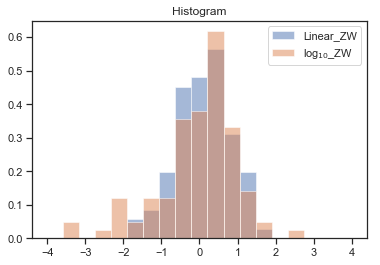

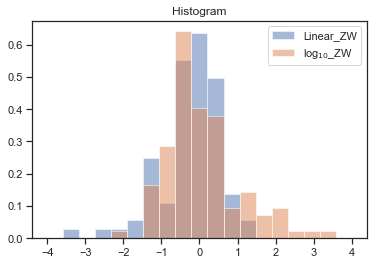

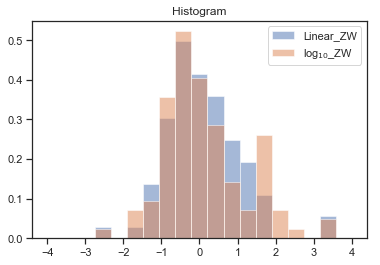

In [101]:

for xx in range(3):
    plt.figure()
    for kk, key in enumerate(resultsOE.keys()):
        x_var = resultsOE[key].x_vars[xx]
        thisOE = resultsOE[key].sel(x_vars=x_var)
        dev = (
        (thisOE.x_op - thisOE.x_truth) /
         thisOE.x_op_err
        )
        dev.plot.hist(bins=np.linspace(-4,4, 20), density=True, alpha=0.5, label=key)
        print(key, dev.mean().values, dev.std().values)
    plt.legend()

In [126]:
resultsOE[key].x_vars.values[kk]

'Dm'

In [122]:
x_var

array('Dm', dtype='<U2')

In [119]:
x_var

'Smprime_log10'

In [115]:
resultsOE['%s %s' % (x_name, y_name)]

<xarray.Dataset>
Dimensions:                    (chi2test: 4, time: 100, x_vars: 3, x_vars_T: 3, y_vars: 2, y_vars_T: 2)
Coordinates:
  * x_vars                     (x_vars) object 'Dm_log10' ... 'Smprime_log10'
  * x_vars_T                   (x_vars_T) object 'Dm_log10' ... 'Smprime_log10'
  * y_vars                     (y_vars) object 'Ze_13.6' 'MDV_13.6'
  * y_vars_T                   (y_vars_T) object 'Ze_13.6' 'MDV_13.6'
  * chi2test                   (chi2test) object 'Y_Optimal_vs_Observation' ... 'X_Optimal_vs_Prior'
  * time                       (time) datetime64[ns] 2011-09-05T09:19:00 ... 2010-03-13T14:57:00
Data variables:
    x_a                        (time, x_vars) float64 0.1533 3.436 ... -0.5305
    x_a_err                    (time, x_vars) float64 0.09772 0.3964 ... 0.07763
    S_a                        (time, x_vars, x_vars_T) float64 0.00955 ... 0.006027
    x_op                       (time, x_vars) float64 0.1342 3.613 ... -0.5064
    x_op_err                   (

In [161]:

df = []

for xx, (x_name, y_name) in enumerate((
    ('Linear', 'ZW'),
#     ('log$_{10}$', 'ZW', 1),
    ('log$_{10}$', 'ZW'),
#     ('log$_{10}$', 'ZW', 2),
)):

    x_vars = ['Nw', 'Dm', 'Smprime']
    y_vars = y_names[y_name]

    y_name2 = '%s' % (y_name)
    x_name2 = '%s' % (x_name)

    for xx, x_var in enumerate(x_vars):
        thisOe = resultsOEMerged['%s %s' % (x_name, y_name,
                                        )].sel(
                                             x_vars=x_var)
        for ii in range(len(thisOe.time)):
            cv = thisOe.chi2value[ii]
            cc = thisOe.chi2critical[ii]
            dgf = thisOe.dgf_x.values[ii]
            re = (thisOe.x_op_err.values[ii] / thisOe.x_op.values[ii])
            ri = (thisOe.x_op_err.values[ii] / thisOe.x_a_err.values[ii])

            df.append((dgf, re, ri, (cv <= cc).all('chi2test').values, np.nan, x_var, x_var.split('_')[0].replace(
                           'prime', ''), y_name2, x_name2))
    for ii in range(len(thisOe.time)):
        cv = thisOe.chi2value[ii]
        cc = thisOe.chi2critical[ii]
        nn = thisOe.trueLinearityChi2.values[ii] < thisOe.trueLinearityChi2Critical.values[ii]
        print(thisOe.trueLinearityChi2.values[ii] ,thisOe.trueLinearityChi2Critical.values[ii])
        dgf_tot = thisOe.dgf.values[ii]
        df.append((dgf_tot, np.nan, np.nan, (cv <= cc).all('chi2test').values,
                       nn, 'total', 'total', y_name2,
                    x_name2))

df = pn.DataFrame(
    df,
    columns=[
        'degrees of freedom', 'relative error', 'relative improvement',
        'chi2Test', 'nonlinearTest', 'x_var', 'x_var_simple', 'y_name',
        'x_name'
    ])

0.06722078760183048 5.991464547107983
0.31367955674935605 5.991464547107983
0.005769629661769316 5.991464547107983
0.015226587199984301 5.991464547107983
0.028511956377455676 5.991464547107983
0.0004597825100980872 5.991464547107983
5.764372332635688e-05 5.991464547107983
0.04821976965146404 5.991464547107983
0.8767498614854776 5.991464547107983
0.4161996414613025 5.991464547107983
0.6913249412809466 5.991464547107983
0.060914999902642195 5.991464547107983
126.72529633391699 5.991464547107983
0.2734651318134358 5.991464547107983
0.12157071105752165 5.991464547107983
0.13838728729026636 5.991464547107983
0.7280173897562496 5.991464547107983
164.9070852663547 5.991464547107983
0.04713693385553916 5.991464547107983
0.006602953899936087 5.991464547107983
0.003925418556974516 5.991464547107983
0.015348519922935924 5.991464547107983
0.0011740666923694568 5.991464547107983
0.24441800577838252 5.991464547107983
0.010664342951242625 5.991464547107983
0.019264777759057987 5.991464547107983
4.471

## relative errors

   \begin{equation}
   \frac{\mathbf{x}_{op} - \mathbf{x}_{truth}}{\sqrt{(\textrm{diag}( \mathbb{S}_y)}}
   \end{equation}



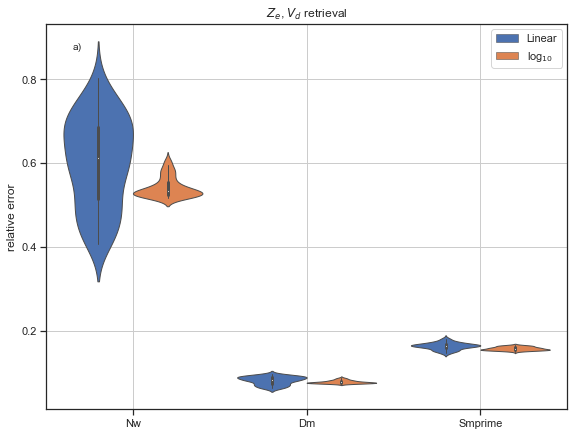

In [162]:
fig, sp = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, 
                      figsize=(8,6))
# sp = sp.ravel()
sp = [sp]


y_sets = ['ZW']
for ii, y_name in enumerate(y_sets):
    data = df[['x_var','relative error','x_name']].where(
        df['chi2Test'] == True
    ).where(
        df.y_name == y_name
    ).dropna(
        0,'any'
    )
    sns.violinplot(
        x='x_var',
        y='relative error',
        hue='x_name',
        data=data,
        saturation=1,
        linewidth=1,
        scale="width",
        ax=sp[ii],
    )
    sp[ii].set_xlabel('')
    sp[ii].set_title(supporting_routines.niceRetrievals[y_name])
    sp[ii].get_legend().remove()
    if ii in [1,3]:
        sp[ii].set_ylabel('')
    sp[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sp[ii].transAxes)
fig.tight_layout(pad=0.5)
sp[0].legend()
sp[0].grid()
# fig.savefig('y_dgf_%s.pdf'%version)

## dgf

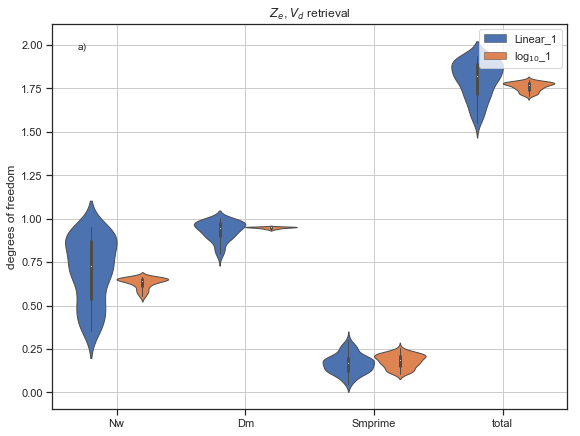

In [20]:
fig, sp = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, 
                      figsize=(8,6))
# sp = sp.ravel()
sp = [sp]


y_sets = ['ZW']
for ii, y_name in enumerate(y_sets):
    data = df.where(
        df.y_name == y_name
    ).where(
        df['chi2Test'] == True
    )
    sns.violinplot(
        x='x_var',
        y='degrees of freedom',
        hue='x_name',
        data=data,
        saturation=1,
        linewidth=1,
        scale="width",
        ax=sp[ii],
    )
    sp[ii].set_xlabel('')
    sp[ii].set_title(supporting_routines.niceRetrievals[y_name])
    sp[ii].get_legend().remove()
    if ii in [1,3]:
        sp[ii].set_ylabel('')
    sp[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sp[ii].transAxes)
fig.tight_layout(pad=0.5)
sp[0].legend()
sp[0].grid()
# fig.savefig('y_dgf_%s.pdf'%version)

## relative improvement

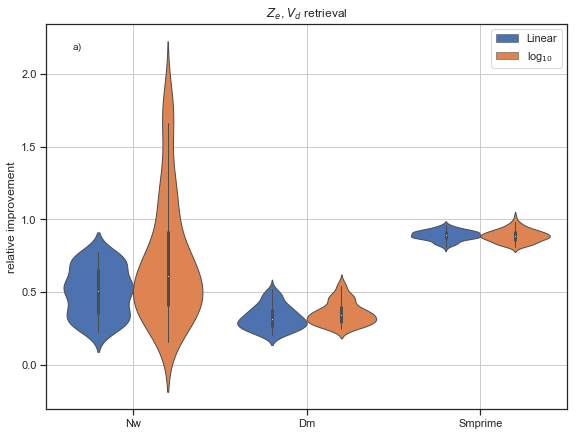

In [163]:
fig, sp = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, 
                      figsize=(8,6))
# sp = sp.ravel()
sp = [sp]


y_sets = ['ZW']
for ii, y_name in enumerate(y_sets):
    data = df[
        ['x_var','relative improvement','x_name']
    ].where(
        df.y_name == y_name
    ).where(
        df['chi2Test'] == True
    ).dropna(
        0, how='any'
    )
    sns.violinplot(
        x='x_var',
        y='relative improvement',
        hue='x_name',
        data=data,
        saturation=1,
        linewidth=1,
        scale="width",
        ax=sp[ii],
    )
    sp[ii].set_xlabel('')
    sp[ii].set_title(supporting_routines.niceRetrievals[y_name])
    sp[ii].get_legend().remove()
    if ii in [1,3]:
        sp[ii].set_ylabel('')
    sp[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sp[ii].transAxes)
fig.tight_layout(pad=0.5)
sp[0].legend()
sp[0].grid()
# fig.savefig('y_dgf_%s.pdf'%version)

Comparison partly unfair due to the sign change in the log scale variables...

## quality tests

converged [%] [86.0, 100.0]
chi2Test [%] [82.0, 92.0]
nonlinearTest [%] [83, 100]


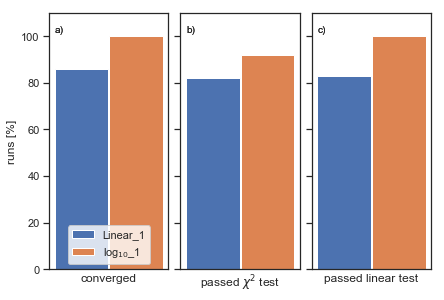

In [22]:
converged = []
nonlinearTest = []
chi2Test = []
# x_names = ['SmLin', 'Sm',  'SmprimeLog10']
# x_names = np.unique((df['x_name']).dropna())
y_name = 'ZW'

x_names1 = [
    'Linear_1', 
            'log$_{10}$_1', 
#             'log$_{10}$_2', 
]

for x_name in x_names1:
    thisII = (df['x_name']==x_name) & (df['y_name']==y_name)
    nSample = (thisII).sum()/4
    converged.append(nSample)
    nonlinearTest.append(df.where(thisII)['nonlinearTest'].sum())
    chi2Test.append((df.where(thisII)['chi2Test'].astype(float)).sum() / 4.)

fig, sps = plt.subplots(ncols=3, sharey=True, figsize=(6,4))
for xx, x_name in enumerate(x_names1):
    sps[0].bar(xx,converged[xx],label=x_name,width=0.98)
    sps[1].bar(xx,chi2Test[xx],label=x_name,width=0.98)
    sps[2].bar(xx,nonlinearTest[xx],label=x_name,width=0.98)

    sps[0].set_xticks([])
    sps[1].set_xticks([])
    sps[2].set_xticks([])
    sps[0].set_xlabel('converged')
    sps[2].set_xlabel('passed linear test')
    sps[1].set_xlabel('passed $\chi^2$ test')




    sps[0].set_ylabel('runs [%]')
    sps[0].set_ylim(0,110)
    sps[0].legend(loc='lower center')
  
    for ii in range(3):
        sps[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sps[ii].transAxes)

fig.tight_layout(pad=0.1, h_pad=0, w_pad=0.)
# fig.savefig('bar_y_%s.pdf'%version)

print('converged [%]', converged)
print('chi2Test [%]', chi2Test)
print('nonlinearTest [%]', nonlinearTest)

In [25]:
oe.linearityTest?